# Variable Selection

In prediction we use a series of independent variables to predict an outcome. We assume that these predictors have a correlation with the dependent variable and hence can be used to establish its value. While this is usually the case, there are scenarios where not all variables have significant effects on the predicted variable. As so, it is useful to carry out some analysis to evaluate the ability of these explanatory variables to influence the prediction as to remove those which have less signifficant impact and hence make the model more parsimonious.

One method used for this purpose is LASSO, which stands for "least absolute shrinkage and selection operator". It is a linear regression with a penality that reduces the beta coefficients to zero at a certain rate. By looking at the path that these coefficients take, one can etablish the variables that are most effective and use these for creating models.

# Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Lasso


# Import Data

In [51]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

#full training set
X = pd.concat([X_train, X_valid, X_test], axis=0)
y = pd.concat([y_train, y_valid, y_test], axis=0)

We modify the Y values to format correctly as per the  `scikitlearn` functions.

In [52]:
y_train = np.array(y_train)
y_train = y_train.ravel()

y = np.array(y)
y = y.ravel()

First we remove the columns that are categorical as these do not work for linear regression

In [53]:
X_train = X_train.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])
X_valid = X_valid.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])
X_test  = X_test.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])

Next we create a column transformer to standardize the numerical values.

In [54]:
std_num = ColumnTransformer(transformers=[('std_num', StandardScaler(), num_vars)],
                            remainder='passthrough')

Then, we create a pipeline to use for future transformations. It is valid to note that regular `scikitlearn` function is used only for linear regression. As classification problems require a binary output, logistic regression is used instead. The equivalent though is to use the $\ell_{1}$-norm penalization of the $\beta$ coefficients.

Additionally, the penalty $\lambda$ is given as the parameter `C` (Cost) in the `LogisticRegression()` function.

In [55]:
lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(penalty='l1', solver='liblinear', C=1, fit_intercept=True, class_weight='balanced'))
])

To find the best combination of parameters for the Lasso regresion, we create a `GridSearch` that runs the function changing the parameters each time. Therefore, we get in a single object the main results for each combination of parameter inputs. 

In [56]:
lasso_grid = np.linspace(start=0.0001, stop=0.2, num=100)

lassoCV = GridSearchCV(estimator=lasso_pipe,
                       param_grid={'lasso_log__C': lasso_grid},
                       scoring="accuracy",
                       cv=KFold(n_splits=10, shuffle=True, random_state=42),
                       n_jobs=-2)

lassoCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_num',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('std_num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'time_spent',
                                                                          'banner_views',
                                                                          'X4'])])),
                                       ('lasso_log',
                                        LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-2,
             param_grid={'l...
       1.53558586e-01, 1.55577778e-01, 1.57596970e-01, 1.59616162e-01,
       1.61635354e-01, 1.63654545e-01, 1.65673737e-01, 1.67692929e-01,
       1.69712121e-01, 1.71731313e-01, 1.73750505e-01, 1.75769697e-01,
       1.77788889e-01, 1.79808081e-01, 1.81827273e-01, 1.83846465e-01,
       1.85865657e-01, 1.87884848e-01, 1.89904040e-01, 1.91923232e-01,
       1.93942424e-01, 1.95961616e-01, 1.97980808e-01, 2.00000000e-01])},
             scoring='accuracy')

In [57]:
pd.DataFrame(lassoCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_log__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023512,0.002942,0.006791,0.001349,0.0001,{'lasso_log__C': 0.0001},0.649123,0.658692,0.645933,0.663477,0.629984,0.633174,0.645367,0.645367,0.656550,0.638978,0.646664,0.010268,100
1,0.024992,0.005099,0.006009,0.001372,0.002119,{'lasso_log__C': 0.002119191919191919},0.757576,0.722488,0.755981,0.751196,0.725678,0.763955,0.739617,0.744409,0.765176,0.736422,0.746250,0.014321,99
2,0.027163,0.003152,0.005718,0.001215,0.004138,{'lasso_log__C': 0.004138383838383839},0.781499,0.752791,0.786284,0.779904,0.770335,0.789474,0.773163,0.765176,0.776358,0.761981,0.773696,0.010827,98
3,0.025977,0.002329,0.005302,0.001061,0.006158,{'lasso_log__C': 0.006157575757575758},0.792663,0.770335,0.797448,0.792663,0.781499,0.795853,0.782748,0.790735,0.784345,0.763578,0.785187,0.010557,97
4,0.025811,0.004791,0.005244,0.001103,0.008177,{'lasso_log__C': 0.008176767676767676},0.811802,0.786284,0.818182,0.802233,0.797448,0.807018,0.789137,0.797125,0.793930,0.777955,0.798111,0.011542,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.039822,0.003489,0.005515,0.001308,0.191923,{'lasso_log__C': 0.19192323232323233},0.822967,0.808612,0.834131,0.830941,0.810207,0.819777,0.797125,0.830671,0.819489,0.816294,0.819021,0.010933,21
96,0.040362,0.005357,0.005475,0.000945,0.193942,{'lasso_log__C': 0.19394242424242425},0.822967,0.810207,0.834131,0.830941,0.810207,0.819777,0.797125,0.830671,0.819489,0.816294,0.819181,0.010791,12
97,0.044465,0.005027,0.005607,0.000830,0.195962,{'lasso_log__C': 0.19596161616161614},0.822967,0.810207,0.834131,0.830941,0.810207,0.819777,0.797125,0.830671,0.819489,0.816294,0.819181,0.010791,12
98,0.042787,0.004777,0.005452,0.000812,0.197981,{'lasso_log__C': 0.19798080808080806},0.822967,0.810207,0.834131,0.830941,0.810207,0.818182,0.797125,0.830671,0.819489,0.816294,0.819021,0.010793,21


As we can see, in this object we have all the parameters and results from running the model multiple times. As such we can use this data to extract which is the best model, that is to say the one that produces the smallest error.

In [58]:
# Choose best model that minimizes cv_err
mean_scores = lassoCV.cv_results_["mean_test_score"]
std_scores = lassoCV.cv_results_["std_test_score"] / np.sqrt(lassoCV.n_splits_)
C_values = lassoCV.cv_results_["param_lasso_log__C"].data

best_index = np.argmax(mean_scores)
max_C_lasso = C_values[best_index]
threshold_lasso = mean_scores[best_index] - std_scores[best_index]
one_std_rule_C_lasso = np.max(C_values[mean_scores <= threshold_lasso])

print("Minimum C:", max_C_lasso)
print("1-SD C:", one_std_rule_C_lasso)
print("Best score for lasso:", np.max(mean_scores))

Minimum C: 0.14952020202020203
1-SD C: 0.04452222222222223
Best score for lasso: 0.8194997732495631


We can use the above variables to plot the behavior of the error through the various calculations.

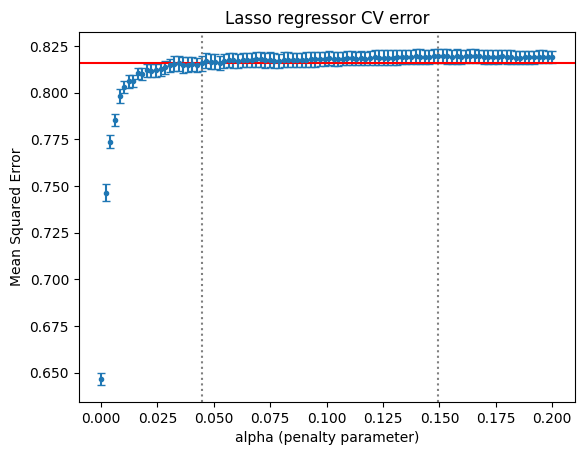

In [59]:
# plt.figure(figsize=(7,6))
plt.errorbar(x=C_values, y=mean_scores, yerr=std_scores, fmt='.', capsize=3)

plt.axvline(x=max_C_lasso, ls='dotted', color="grey")  # vertical line at the k yielding minimum CV MSE
plt.axvline(x=one_std_rule_C_lasso, ls='dotted', color="grey")   # vertical line at best k value according to 1 std err rule
plt.axhline(y=threshold_lasso, color="red")  # horizontal line line at best k value according to 1 std err rule

plt.title("Lasso regressor CV error")
plt.xlabel('alpha (penalty parameter)')
plt.ylabel('Mean Squared Error')
plt.show()

Now we can use the result of the best Lasso regression to predict the values of the validation data set and check its accuracy.

In [60]:
y_valid_pred = lassoCV.predict(X_valid)
accuracy_score(y_valid_pred, y_valid)

0.806403574087863

Having the model set up, we can generate the parameters required to plot the behaviour of the $\Beta$ coefficients and have a better understanding of which variables are most important.

In [61]:
#create lambda matrix
lasso_grid = np.linspace(start=0.0001, stop=0.2, num=100)

#extablish coefficient set
coefs_ = []
for C in lasso_grid:
    lasso_pipe.set_params(lasso_log__C=C) 
    lasso_pipe.fit(X=X_train, y=y_train)
    coefs_.append(lasso_pipe.named_steps['lasso_log'].coef_.ravel().copy()) #extract the parameters and store to the set

coefs_ = np.array(coefs_)

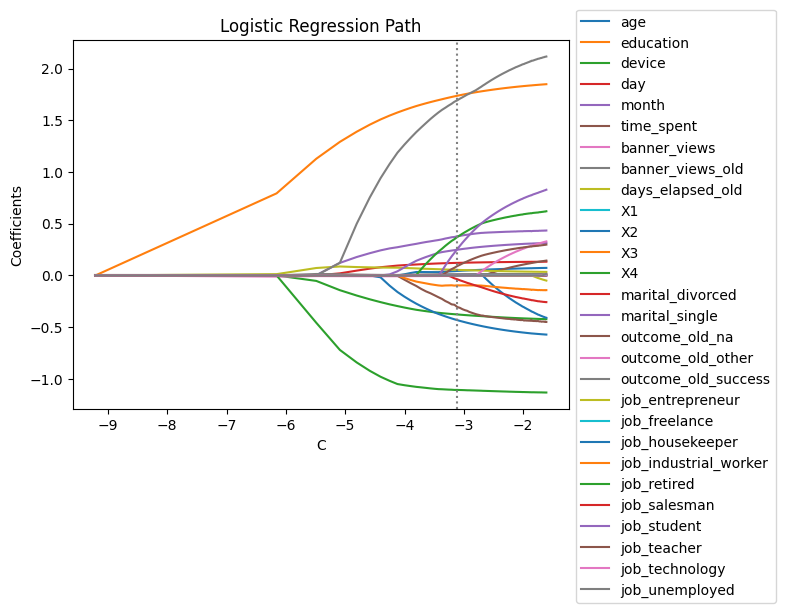

In [62]:
#plot the data
plt.plot(np.log(lasso_grid), coefs_, label=X_train.columns)
ymin, ymax = plt.ylim()
plt.axvline(x=np.log(one_std_rule_C_lasso), ls='dotted', color="grey")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.1))
plt.xlabel("C")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

Now that we know which are the best parameters, we can instantiate an optimal lasso regression to evaluate the predictive performance of this model with regards to the validation and test sets.

In [63]:
lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(penalty='l1', solver='liblinear', C=one_std_rule_C_lasso, fit_intercept=True, class_weight='balanced'))
])

lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('std_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_num', StandardScaler(),
                                                  ['age', 'time_spent',
                                                   'banner_views', 'X4'])])),
                ('lasso_log',
                 LogisticRegression(C=0.04452222222222223,
                                    class_weight='balanced', penalty='l1',
                                    solver='liblinear'))])

In [64]:
print("Training accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_train), y_true=y_train),4))
print("Validation accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_valid), y_true=y_valid),4))
print("Test accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_test), y_true=y_test),4))

Training accuracy: 0.8184
Validation accuracy: 0.8004
Test accuracy: 0.822


As we can see, while the training accuracy is not the highest, it still performs similarly with the validation and test sets. 

Finally, we can plot the importance of the variables to more clearly see which have larger predictive power. 

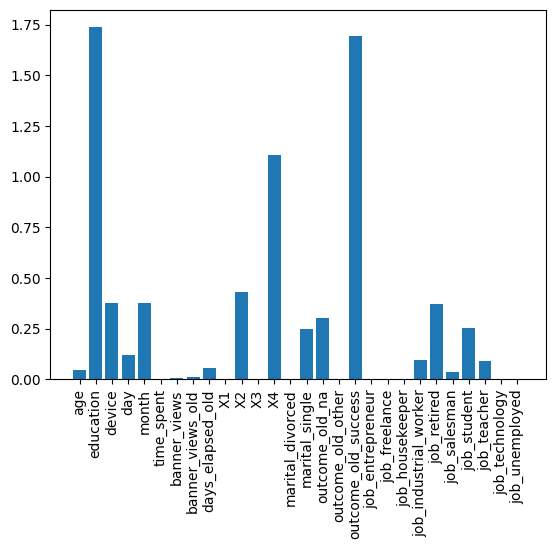

In [65]:
#extract values from fitted model
lasso_coefs = lasso_pipe.named_steps['lasso_log'].coef_
lasso_coefs = lasso_coefs.ravel()

#create dataframe with column names and respective coefficients
lasso_coefs = pd.DataFrame({'col_names': X_train.columns, 'coef': lasso_coefs})

#plot the variable importance
plt.bar(lasso_coefs['col_names'], np.abs(lasso_coefs['coef']))
plt.xticks(rotation = 90)
plt.show()

From the plot, we can see that `outcome_old_success`, `education`, and `x4` have the highest predictive powers, while various others have lesser importance. However not all are insignifficant. Regardless, we remove the columns which do have a coefficient that reach the value of 0. 

In [66]:
cols_lasso = ['banner_views_old', 'days_elapsed_old', 'X3', 'marital_divorced', 'job_entrepreneur', 'job_freelance',
             'job_housekeeper', 'job_technology', 'job_unemployed']

Next, we recreate our pipeline and adjust the training data set to evaluate the performance of the model with only the variables that are considered relevant.

In [67]:
num_vars = ['age', 'time_spent', 'banner_views', 'X4']
std_num = ColumnTransformer(transformers=[('std_num', StandardScaler(), num_vars)],
                            remainder='passthrough')

X_train_reduced = X_train.drop(columns=cols_lasso)
X_valid_reduced = X_valid.drop(columns = cols_lasso)
X_test_reduced = X_test.drop(columns=cols_lasso)
X_reduced = X.drop(columns=cols_lasso)

lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'))
])

## Results: Lasso Best Model

In [48]:
#Print the results
print("Lasso Best Model")
print(" ")

#fit and predict on partitioned data set
lasso_pipe.fit(X_train_reduced, y_train)
print("Training accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_train_reduced), y_true=y_train),4))
print("Validation accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_valid_reduced), y_true=y_valid),4))
print("Test accuracy:", round(accuracy_score(y_pred=lasso_pipe.predict(X_test_reduced), y_true=y_test),4))
print("X accuracy for Partially Trained Model:", round(accuracy_score(y_pred=lasso_pipe.predict(X_reduced), y_true=y),4))

#fit and predict on all data
lasso_pipe.fit(X_reduced,y)
print("X accuracy on Fully Trained Model:", round(accuracy_score(y_pred=lasso_pipe.predict(X_reduced), y_true=y),4))

Lasso Best Model
 
Training accuracy: 0.8043
Validation accuracy: 0.7826
Test accuracy: 0.8057
X accuracy for Partially Trained Model: 0.8013
X accuracy on Fully Trained Model: 0.8027
